# Optimización Bayesiana

En este notebook se muestra la obtención de hiperparámetros óptimos para una red neuronal utilizando optimización bayesiana. Esta técnica es más eficiente que un Gridsearch o Manual tuning para casos (como el actual) en el que no se tienen recursos para realizar entrenamientos en paralelo de modelos.


https://arxiv.org/pdf/1807.02811.pdf

**NOTA:** Este notebook está ejecutado en *Google Colab*

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install --upgrade pandas
!pip install --upgrade matplotlib==2.1.1
!pip install scikit-optimize

    100% |████████████████████████████████| 10.1MB 4.3MB/s 
fastai 1.0.49 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0


    100% |████████████████████████████████| 15.0MB 2.6MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.49 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: matplotlib 3.0.3
    Uninstalling matplotlib-3.0.3:
      Successfully uninstalled matplotlib-3.0.3


    100% |████████████████████████████████| 81kB 3.7MB/s 


In [1]:
!ls "drive/My Drive/Colab Notebooks/data"

data_kaggle_proc.pickle		       news_proc_12_3_19.pickle
GoogleNews-vectors-negative300.bin.gz


# Imports, loads and Train/test split
---

In [ ]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
data = pd.read_pickle('drive/My Drive/Colab Notebooks/data/news_proc_12_3_19.pickle')#.reset_index()
data = data.dropna()

Labels asignadas a los tipos

In [4]:
types = data['type'].unique()
for t in types:
    print("{} - {}".format(t, data[data['type'] == t].head(1)['one_hot_label'].iloc[0]))

bias - [1 0 0 0]
click - [0 1 0 0]
fake - [0 0 1 0]
truth - [0 0 0 1]


In [5]:
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1598
Max len title: 13


In [ ]:
model = KeyedVectors.load_word2vec_format("drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000)

In [ ]:
embed_mat = np.zeros((50000,300))
for i, e in model.vocab.items():
    embed_mat[e.index] = model[i]

**Tran/valid/test split**

In [ ]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['one_hot_label'], test_size=0.3, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

In [ ]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_valid_title = X_valid['title']
X_valid_content = X_valid['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [ ]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()), 
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [ ]:
del data
del X_train_title, X_train_content
del X_valid_title, X_valid_content
del X_test_title, X_test_content

# Buscar hiperparámetros óptimos para la CNN

In [ ]:
import skopt
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective

from numpy.random import seed
from tensorflow import set_random_seed

In [ ]:
space  = [Real(1e-3, 0.4, name='lr'),
          Real(1e-3, 0.4, name='momentum')]

In [ ]:
@use_named_args(space)
def cnn_model(**params):
    
    x_train = train_fit
    y_train2 = np.array(y_train.tolist())
    
    x_valid = valid_fit
    y_valid2 = np.array(y_valid.tolist())
    
    x_test = test_fit
    y_test2 = np.array(y_test.tolist())

    #Reproducible
    seed(50)
    set_random_seed(50)
    k.backend.clear_session()
    
    
    
    #input_title
    title_input = k.layers.Input(shape=(len_title,), name='title_input')
    inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False, name='embed_title')(title_input)

    x = k.layers.Conv1D(filters = 10, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
    x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
    x = k.layers.Flatten()(x)
    x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

    #input_content
    content_input = k.layers.Input(shape=(len_content,), name='content_input')
    inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                             weights=[embed_mat], trainable=False, name='embed_content')(content_input)
    x2 = k.layers.Conv1D(filters = 60, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
    x2 = k.layers.MaxPool1D(pool_size = 6, name='Pool1Content')(x2)
    
    x2 = k.layers.Conv1D(filters = 80, kernel_size = 8, strides = 4, activation='relu', name='Conv2Content')(inp2)
    x2 = k.layers.MaxPool1D(pool_size = 2, name='Pool2Content')(x2)

    x2 = k.layers.Flatten()(x2)
    x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


    #Merge
    x = k.layers.concatenate([x, x2])

    #Common part
    x = k.layers.Dense(100, activation='relu')(x)
    x = k.layers.Dropout(0.2)(x)
    x = k.layers.Dense(50, activation='relu')(x)
    x = k.layers.Dropout(0.2)(x)
    out = k.layers.Dense(4, activation='softmax')(x)


    #Build model
    model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

    model.compile(k.optimizers.SGD(lr=params['lr'], momentum=params['momentum']), loss='categorical_crossentropy', metrics=['acc'])
    
    out = model.fit(x=x_train, y=y_train2, batch_size=128, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta = 0.1)], 
                    validation_data=(x_valid, y_valid2))
    
    
    #Evaluation
    
    acc = model.evaluate(x=x_test, y=y_test2)
    return -acc[1] #Maximize accuracy

In [25]:
r = skopt.gp_minimize(cnn_model, n_random_starts=3, n_calls=5, dimensions=space)

Train on 94319 samples, validate on 40423 samples
Epoch 1/20
94319/94319 [==============================] - 56s 597us/sample - loss: 1.0498 - acc: 0.6651 - val_loss: 0.6692 - val_acc: 0.7814
Epoch 2/20
94319/94319 [==============================] - 56s 590us/sample - loss: 0.6688 - acc: 0.7857 - val_loss: 0.6329 - val_acc: 0.8018
Epoch 3/20
57747/57747 [==============================] - 20s 348us/sample - loss: 0.6240 - acc: 0.8132
Train on 94319 samples, validate on 40423 samples
Epoch 1/20
94319/94319 [==============================] - 56s 594us/sample - loss: 1.0701 - acc: 0.6819 - val_loss: 0.6468 - val_acc: 0.7860
Epoch 2/20
94319/94319 [==============================] - 56s 590us/sample - loss: 0.6474 - acc: 0.7952 - val_loss: 0.6079 - val_acc: 0.8078
Epoch 3/20
57747/57747 [==============================] - 20s 349us/sample - loss: 0.6105 - acc: 0.8178
Train on 94319 samples, validate on 40423 samples
Epoch 1/20
94319/94319 [==============================] - 56s 595us/sample - l

Podemos aceder a los parámetros con los que se obtiene el mínimo en la función de loss (máximo en nuestro caso)

In [27]:
print("PARAMETERS (LR/Optimizer): {}  RESULT {}".format(r.x, r.fun))

PARAMETERS (LR/Optimizer): [0.23993334664040306, 0.30361299021107185]  RESULT -0.8178433775901794


Como vemos, con estos parámetros se obtiene un accuracy de 0.81 en el conjunto de validación.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e42b9c048>,
      dtype=object)

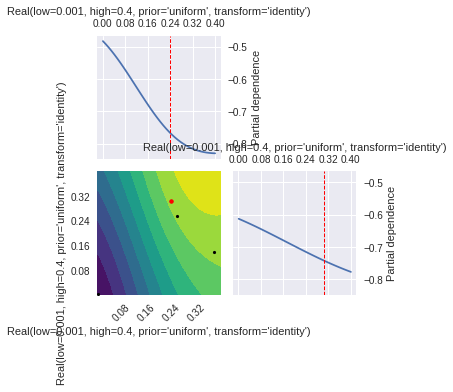

In [30]:
plot_objective(r, dimensions=space)